In [1]:
import pandas as pd
import numpy as np
import datetime
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

from xgboost import XGBRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2

%matplotlib inline

### Data
---

In [2]:
df = pd.read_csv('./data/combined.csv')

In [3]:
df.head()

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,q_avghumid,q_sumprecip,sunHour,FIRE_NAME,CAUSE,lat,long,GIS_ACRES
0,2008-07,Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,34.079570,0.010000,13.164516,no_fire,0.0,34.54,-120.04,0.000000
1,2008-07,Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,38.434409,0.068065,14.022581,SERPENTINE,1.0,38.18,-120.56,176.763400
2,2008-07,Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,38.434409,0.068065,14.022581,POOL 2 - MAIN,10.0,38.18,-120.56,73.444778
3,2008-07,Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,38.434409,0.068065,14.022581,FRENCH,14.0,38.18,-120.56,101.074150
4,2008-07,Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,38.434409,0.068065,14.022581,EVANS,6.0,38.18,-120.56,103.968050


In [4]:
df = df.drop(columns=['FIRE_NAME', 'lat', 'long'])

In [5]:
df['bool'] = (df['GIS_ACRES'] > 0) * 1
df.head(1)

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,q_avghumid,q_sumprecip,sunHour,CAUSE,GIS_ACRES,bool
0,2008-07,Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,34.07957,0.01,13.164516,0.0,0.0,0


In [6]:
df['date'] = [x.split('-') for x in df['date']]
df.head(1)

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,q_avghumid,q_sumprecip,sunHour,CAUSE,GIS_ACRES,bool
0,"[2008, 07]",Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,34.07957,0.01,13.164516,0.0,0.0,0


In [7]:
df['year'] = [int(x[0]) for x in df['date']]
df.head(1)

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,q_avghumid,q_sumprecip,sunHour,CAUSE,GIS_ACRES,bool,year
0,"[2008, 07]",Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,34.07957,0.01,13.164516,0.0,0.0,0,2008


In [8]:
df['month'] = [int(x[1]) for x in df['date']]
df.head(1)

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,q_avghumid,q_sumprecip,sunHour,CAUSE,GIS_ACRES,bool,year,month
0,"[2008, 07]",Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,34.07957,0.01,13.164516,0.0,0.0,0,2008,7


In [9]:
df.shape

(10988, 18)

In [10]:
df_dummy = pd.get_dummies(df, columns=['month'])
df.head(1)

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,q_avghumid,q_sumprecip,sunHour,CAUSE,GIS_ACRES,bool,year,month
0,"[2008, 07]",Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,34.07957,0.01,13.164516,0.0,0.0,0,2008,7


In [11]:
df_dummy.head(1)

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,"[2008, 07]",Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,...,False,False,False,False,True,False,False,False,False,False


In [12]:
# test = ['2008', '07']
# datetime.datetime(int(test[0]), int(test[1]), 1).timestamp()

In [13]:
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10988 entries, 0 to 10987
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         10988 non-null  object 
 1   county       10988 non-null  object 
 2   maxtempF     10988 non-null  float64
 3   mintempF     10988 non-null  float64
 4   avgtempF     10988 non-null  float64
 5   totalSnow    10988 non-null  float64
 6   humid        10988 non-null  float64
 7   wind         10988 non-null  float64
 8   precip       10988 non-null  float64
 9   q_avgtempF   10988 non-null  float64
 10  q_avghumid   10988 non-null  float64
 11  q_sumprecip  10988 non-null  float64
 12  sunHour      10988 non-null  float64
 13  CAUSE        10988 non-null  float64
 14  GIS_ACRES    10988 non-null  float64
 15  bool         10988 non-null  int64  
 16  year         10988 non-null  int64  
 17  month_1      10988 non-null  bool   
 18  month_2      10988 non-null  bool   
 19  mont

In [14]:
df_dummy.head()

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,"[2008, 07]",Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,...,False,False,False,False,True,False,False,False,False,False
1,"[2008, 07]",Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,...,False,False,False,False,True,False,False,False,False,False
2,"[2008, 07]",Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,...,False,False,False,False,True,False,False,False,False,False
3,"[2008, 07]",Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,...,False,False,False,False,True,False,False,False,False,False
4,"[2008, 07]",Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,...,False,False,False,False,True,False,False,False,False,False


### Classification
---

In [15]:
X = df_dummy.drop(columns=['GIS_ACRES', 'date', 'q_avgtempF', 'q_avghumid', 'q_sumprecip', 'maxtempF', 'mintempF', 'CAUSE', 'bool', 'county'])
y = df_dummy['bool']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [16]:
df['bool'].value_counts(normalize=True) #Unbalanced data

bool
0    0.638424
1    0.361576
Name: proportion, dtype: float64

## mlflow

import mlflow

In [17]:
import mlflow
from mlflow.tracking.client import MlflowClient
mlflow.set_experiment("wildfire-prediction")

<Experiment: artifact_location='file:///c:/Users/ygz08/Desktop/Git/localgit/MLOPs/Predictable_wildfire/mlruns/805848653222892541', creation_time=1746175907264, experiment_id='805848653222892541', last_update_time=1746175907264, lifecycle_stage='active', name='wildfire-prediction', tags={}>

## 羅吉斯回歸

In [18]:
from sklearn.linear_model import LogisticRegression

with mlflow.start_run(run_name='LogisticRegression'):#mlflow
    mlflow.tensorflow.autolog()#mlflow
    max_iter=1000 
    #mlflow.log_param("max_iter", max_iter) #mlflow紀錄參數n_estimators
# 方法四：使用 class_weight='balanced'
    log_reg = LogisticRegression(max_iter=max_iter, class_weight='balanced')
    log_reg.fit(X_train, y_train)
    run_id = mlflow.active_run().info.run_id#mlflow
    print(f"Model saved in run {run_id}")#mlflow
    

    # 檢查訓練與測試分數
    print("Train score:", log_reg.score(X_train, y_train))
    print("Test score:", log_reg.score(X_test, y_test))

    mlflow.log_metric("Train score", log_reg.score(X_train, y_train))#mlflow
    mlflow.log_metric("Test score", log_reg.score(X_test, y_test))#mlflow


    # 存檔模型mlflow
    model_name = "LogisticRegression-model"
    mlflow.sklearn.log_model(     #mlflow.sklearn.log_model() #紀錄sklearn模型
        sk_model=log_reg, 
        artifact_path="LogisticRegression-model",
        registered_model_name=model_name,  #
    )



C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model saved in run 5084c6bd37594f3e8c12feacc6ec553c
Train score: 0.7434663892861787
Test score: 0.7573551713679102


2025/05/02 21:41:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'LogisticRegression-model'.
Created version '1' of model 'LogisticRegression-model'.


In [19]:
#description="Logistic Regression model with class_weight='balanced'"


###  羅吉斯回歸-混淆矩陣

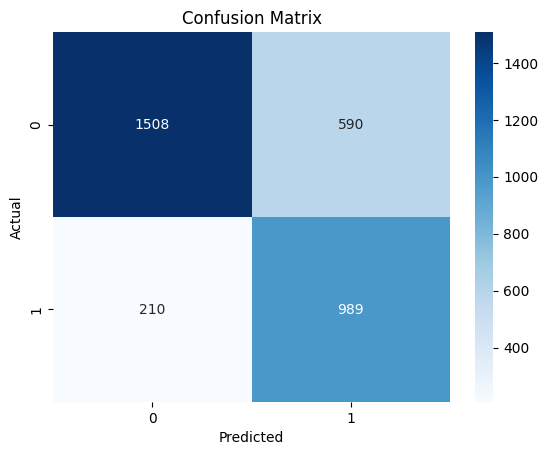

Classification Report:

              precision    recall  f1-score   support

           0     0.8778    0.7188    0.7904      2098
           1     0.6263    0.8249    0.7120      1199

    accuracy                         0.7574      3297
   macro avg     0.7521    0.7718    0.7512      3297
weighted avg     0.7863    0.7574    0.7619      3297



In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = log_reg.predict(X_test)

# 混淆矩陣
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# classification report（包含 precision, recall, f1-score）
print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

In [21]:
pd.set_option('display.max_row', None)

In [22]:
coef_df = pd.DataFrame(log_reg.coef_, columns=X.columns)
coef_df.T.sort_values(by=0, ascending=False).head(77)

,0
month_8,1.088163
month_11,0.647992
month_9,0.551165
sunHour,0.542979
month_12,0.468268
month_7,0.265440
month_10,0.086014
totalSnow,0.009221
year,-0.001591
avgtempF,-0.006095


In [23]:
log_reg.coef_

array([[-0.00609488,  0.00922107, -0.02593307, -0.26969065, -0.43966367,
         0.54297853, -0.00159086, -0.5240136 , -0.91722015, -0.59754993,
        -0.37368111, -0.45151369, -0.27830824,  0.2654397 ,  1.08816347,
         0.55116498,  0.08601395,  0.64799208,  0.46826796]])

- 這段程式碼是在對特徵進行標準化（`Standardization）`，讓每個特徵轉換成平均值為 0、標準差為 `1 的分佈，這對像是 Logistic Regression、SVM、KNN` 等模型尤其重要。

In [24]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

## KNN

Model saved in run 7b248524522645c997858d064be01bcf
Train Accuracy: 0.9986997789624236
Test Accuracy: 0.8492569002123143


2025/05/02 21:41:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'knn-model'.
Created version '1' of model 'knn-model'.


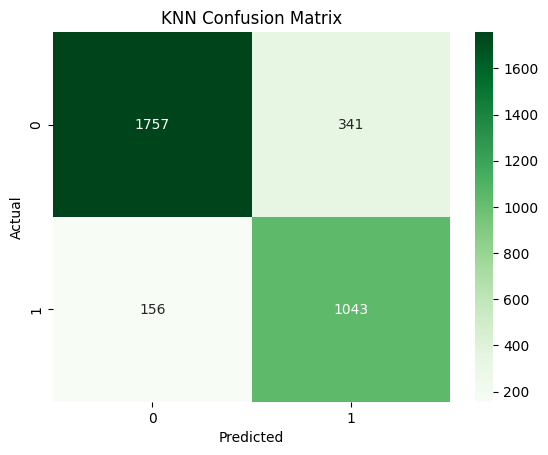

Classification Report:

              precision    recall  f1-score   support

           0     0.9185    0.8375    0.8761      2098
           1     0.7536    0.8699    0.8076      1199

    accuracy                         0.8493      3297
   macro avg     0.8360    0.8537    0.8418      3297
weighted avg     0.8585    0.8493    0.8512      3297



In [25]:

#KNN 
# N=3
#Train Accuracy: 0.9986997789624236
#Test Accuracy: 0.8495602062481044
with mlflow.start_run(run_name='knn'):#mlflow
    mlflow.log_param("n_neighbors", 5)
    mlflow.log_param("weights", "distance")

    knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
    knn.fit(X_train_sc, y_train)
    
    run_id = mlflow.active_run().info.run_id#mlflow
    print(f"Model saved in run {run_id}")#mlflow

    # 預測
    y_pred_knn = knn.predict(X_test_sc)

    # Train / Test accuracy
    print("Train Accuracy:", knn.score(X_train_sc, y_train))
    print("Test Accuracy:", knn.score(X_test_sc, y_test))

    #mlflow
    mlflow.log_metric("Train score", knn.score(X_train_sc, y_train))#mlflow
    mlflow.log_metric("Test score", knn.score(X_test_sc, y_test))#mlflow
    mlflow.sklearn.log_model(     #mlflow.sklearn.log_model() #紀錄sklearn模型
        sk_model=knn, 
        artifact_path="knn-model",
        registered_model_name="knn-model",  #
    )


    # 混淆矩陣
    cm2 = confusion_matrix(y_test, y_pred_knn)
    sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("KNN Confusion Matrix")
    plt.show()

    # classification report
    print("Classification Report:\n")
    print(classification_report(y_test, y_pred_knn, digits=4))

## RF 隨機森林

Train Accuracy: 0.9713951371733195
Test Accuracy: 0.8738246891113133


2025/05/02 21:41:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'RandomForest-model'.
Created version '1' of model 'RandomForest-model'.


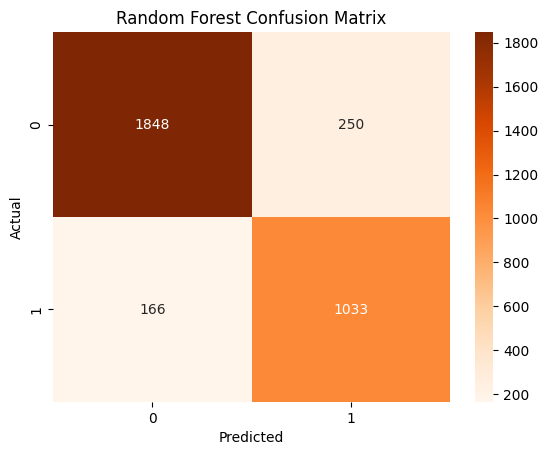

Classification Report:

              precision    recall  f1-score   support

           0     0.9176    0.8808    0.8988      2098
           1     0.8051    0.8616    0.8324      1199

    accuracy                         0.8738      3297
   macro avg     0.8614    0.8712    0.8656      3297
weighted avg     0.8767    0.8738    0.8747      3297



In [26]:
#Random Forest 隨機森林

#Train Accuracy: 0.9837472370302951
#Test Accuracy: 0.8823172581134364
with mlflow.start_run(run_name='RandomForest'):#mlflow
    n_estimators = 150 #樹的數量
    max_depth = 15 #樹的深度
    
    mlflow.log_param("n_estimators", n_estimators) #mlflow
    mlflow.log_param("max_depth", max_depth) #mlflow
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight='balanced')
    rf.fit(X_train, y_train)

    # 預測
    y_pred_rf = rf.predict(X_test)

    # 準確率
    print("Train Accuracy:", rf.score(X_train, y_train))
    print("Test Accuracy:", rf.score(X_test, y_test))

    mlflow.log_metric("Train score", rf.score(X_train, y_train))#mlflow
    mlflow.log_metric("Test score", rf.score(X_test, y_test))#mlflow

    mlflow.sklearn.log_model(     #mlflow.sklearn.log_model() #紀錄sklearn模型
        sk_model=log_reg, 
        artifact_path="RandomForest-model",
        registered_model_name='RandomForest-model',  
    )   

    # 混淆矩陣
    cm3 = confusion_matrix(y_test, y_pred_rf)
    sns.heatmap(cm3, annot=True, fmt='d', cmap='Oranges', xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Random Forest Confusion Matrix")
    plt.show()

    # classification report
    print("Classification Report:\n")
    print(classification_report(y_test, y_pred_rf, digits=4))

In [27]:
rf.feature_importances_

array([0.2163437 , 0.01557556, 0.18585838, 0.12422079, 0.09686764,
       0.21700056, 0.06405259, 0.00477509, 0.00395362, 0.00297158,
       0.00655754, 0.00681671, 0.00603357, 0.01872042, 0.00989598,
       0.00709565, 0.00661707, 0.00326182, 0.00338173])

In [28]:
feature_df = pd.DataFrame(rf.feature_importances_, index=X.columns)
feature_df.sort_values(by=0, ascending=False)

,0
sunHour,0.217001
avgtempF,0.216344
humid,0.185858
wind,0.124221
precip,0.096868
year,0.064053
month_7,0.018720
totalSnow,0.015576
month_8,0.009896
month_9,0.007096


In [29]:
log_reg.predict(X_test)
knn.predict(X_test)
rf.predict(X_test)

C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


array([1, 0, 0, ..., 0, 0, 0])

In [30]:
pred_df = pd.DataFrame(columns=['log_reg', 'knn', 'rf'])
pred_df['log_reg'] = log_reg.predict(X_test)
pred_df['knn'] = knn.predict(X_test)
pred_df['rf'] = rf.predict(X_test)
pred_df['ensemble'] = (pred_df.sum(axis=1)/3).round(0)
pred_df.head()

C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


,log_reg,knn,rf,ensemble
0,1,0,1,1.0
1,0,0,0,0.0
2,0,0,0,0.0
3,1,0,1,1.0
4,0,0,0,0.0


In [31]:
metrics.accuracy_score(pred_df['ensemble'], y_test)

0.8092205034880194

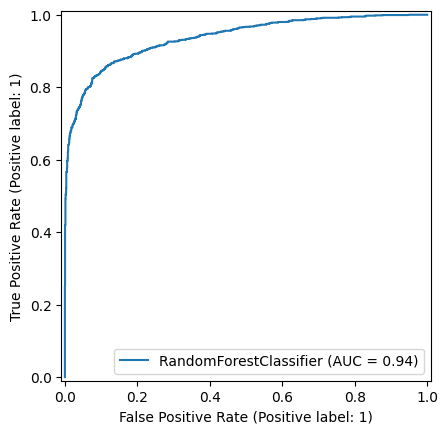

In [32]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(rf, X_test, y_test)

## DNN

In [33]:
with mlflow.start_run(run_name='DNN'):#mlflow
    mlflow.tensorflow.autolog()#mlflow    

    n_input = X_train.shape[1]

    model = Sequential()
    model.add(BatchNormalization())
    model.add(Dense(256, input_shape=(n_input,), activation='relu'))
    model.add(Dropout(0.1))  # 增加 Dropout 率，避免過擬合
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.1))  # Dropout 率可根據需要進行調整
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))  # Dropout 率可根據需要進行調整
    model.add(Dense(1, activation='sigmoid'))


    # 模型optimizer 和 learning rate


    initial_lr = 0.001
    from tensorflow.keras.optimizers import schedules
    lr_schedule = schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)
    from tensorflow.keras.optimizers import Adam
    optimizer = Adam(learning_rate=lr_schedule)

    mlflow.log_param("loss", 'bce') #mlflow
    model.compile(loss='bce', optimizer=optimizer, metrics=['acc', 'Recall', 'Precision'])

    # EarlyStopping: 根據 val_loss 停止訓練
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    # ModelCheckpoint: 儲存最佳模型
    from tensorflow.keras.callbacks import ModelCheckpoint
    checkpoint = ModelCheckpoint('./models_temp/DNN_best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128, verbose=1)

    train_loss, train_acc, train_recall, train_precision = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_acc, test_recall, test_precision = model.evaluate(X_test, y_test, verbose=0)
    mlflow.log_metric("Train score", train_acc)#mlflow
    mlflow.log_metric("Test score", test_acc)#mlflow
    #註冊模型
    run_id = mlflow.active_run().info.run_id#mlflow
    result = mlflow.register_model(
        model_uri=f"runs:/{run_id}/model",  # 你要用 mlflow.log_model 存的位置
        name="DNN-model"              # 註冊後的 model name
    )

    
    model.evaluate(X_test, y_test)

C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025/05/02 21:41:26 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: Sequential model 'sequential' has no defined input shape yet.
2025/05/02 21:41:26 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.
2025/05/02 21:41:26 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'


Epoch 1/100
47/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.5632 - Recall: 0.4904 - acc: 0.6759 - loss: 0.5524

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - Precision: 0.5791 - Recall: 0.5215 - acc: 0.6886 - loss: 0.5420 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_acc: 0.6363 - val_loss: 10.5527
Epoch 2/100
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6668 - Recall: 0.6720 - acc: 0.7570 - loss: 0.4817

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6649 - Recall: 0.6702 - acc: 0.7564 - loss: 0.4814 - val_Precision: 0.7535 - val_Recall: 0.4003 - val_acc: 0.7343 - val_loss: 0.5465
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6727 - Recall: 0.7070 - acc: 0.7682 - loss: 0.4707 - val_Precision: 0.3649 - val_Recall: 0.9992 - val_acc: 0.3673 - val_loss: 3.3161
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6770 - Recall: 0.6517 - acc: 0.7645 - loss: 0.4684 - val_Precision: 0.4124 - val_Recall: 0.9641 - val_acc: 0.4874 - val_loss: 1.3502
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6772 - Recall: 0.7364 - acc: 0.7714 - loss: 0.4639 - val_Precision: 0.3708 - val_Recall: 0.9992 - val_acc: 0.3831 - val_loss: 2.6939
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6682 - Recall: 0.7163 - acc: 0.7675 - loss: 0.4665 - val_Precision: 0.5637 - val_Recall: 0.7089 - val_acc: 0.6946 - val_loss: 0.6248
Epoch 7/100
61/61

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6767 - Recall: 0.7148 - acc: 0.7726 - loss: 0.4554 - val_Precision: 0.6452 - val_Recall: 0.7281 - val_acc: 0.7555 - val_loss: 0.5352
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6853 - Recall: 0.6845 - acc: 0.7712 - loss: 0.4601

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6853 - Recall: 0.6845 - acc: 0.7713 - loss: 0.4600 - val_Precision: 0.6691 - val_Recall: 0.6947 - val_acc: 0.7640 - val_loss: 0.4874
Epoch 10/100
47/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6847 - Recall: 0.7282 - acc: 0.7869 - loss: 0.4497

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6861 - Recall: 0.7226 - acc: 0.7855 - loss: 0.4507 - val_Precision: 0.6485 - val_Recall: 0.7631 - val_acc: 0.7634 - val_loss: 0.4775
Epoch 11/100
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.6914 - Recall: 0.7292 - acc: 0.7918 - loss: 0.4392

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6912 - Recall: 0.7294 - acc: 0.7914 - loss: 0.4397 - val_Precision: 0.6926 - val_Recall: 0.7064 - val_acc: 0.7792 - val_loss: 0.4594
Epoch 12/100
48/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7193 - Recall: 0.6542 - acc: 0.7815 - loss: 0.4532

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7162 - Recall: 0.6626 - acc: 0.7821 - loss: 0.4520 - val_Precision: 0.6972 - val_Recall: 0.7298 - val_acc: 0.7865 - val_loss: 0.4517
Epoch 13/100
48/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7057 - Recall: 0.6907 - acc: 0.7871 - loss: 0.4316

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7052 - Recall: 0.6939 - acc: 0.7869 - loss: 0.4336 - val_Precision: 0.6892 - val_Recall: 0.7473 - val_acc: 0.7856 - val_loss: 0.4492
Epoch 14/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6924 - Recall: 0.7254 - acc: 0.7876 - loss: 0.4315 - val_Precision: 0.6933 - val_Recall: 0.7598 - val_acc: 0.7904 - val_loss: 0.4515
Epoch 15/100
49/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7243 - Recall: 0.6981 - acc: 0.7913 - loss: 0.4411

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7229 - Recall: 0.6989 - acc: 0.7917 - loss: 0.4402 - val_Precision: 0.6913 - val_Recall: 0.7415 - val_acc: 0.7856 - val_loss: 0.4443
Epoch 16/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7017 - Recall: 0.7448 - acc: 0.7923 - loss: 0.4376 - val_Precision: 0.6927 - val_Recall: 0.7556 - val_acc: 0.7892 - val_loss: 0.4477
Epoch 17/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7044 - Recall: 0.7538 - acc: 0.7945 - loss: 0.4318

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7045 - Recall: 0.7535 - acc: 0.7945 - loss: 0.4318 - val_Precision: 0.6994 - val_Recall: 0.7415 - val_acc: 0.7901 - val_loss: 0.4399
Epoch 18/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7224 - Recall: 0.7200 - acc: 0.7974 - loss: 0.4280 - val_Precision: 0.7217 - val_Recall: 0.7073 - val_acc: 0.7944 - val_loss: 0.4421
Epoch 19/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7209 - Recall: 0.7233 - acc: 0.8013 - loss: 0.4177

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7208 - Recall: 0.7234 - acc: 0.8013 - loss: 0.4178 - val_Precision: 0.7072 - val_Recall: 0.7231 - val_acc: 0.7904 - val_loss: 0.4351
Epoch 20/100
56/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.7475 - Recall: 0.7348 - acc: 0.8142 - loss: 0.4164

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7454 - Recall: 0.7345 - acc: 0.8131 - loss: 0.4168 - val_Precision: 0.6949 - val_Recall: 0.7673 - val_acc: 0.7928 - val_loss: 0.4344
Epoch 21/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7143 - Recall: 0.7377 - acc: 0.7977 - loss: 0.4210 - val_Precision: 0.7340 - val_Recall: 0.7248 - val_acc: 0.8044 - val_loss: 0.4399
Epoch 22/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7427 - Recall: 0.7031 - acc: 0.8050 - loss: 0.4146 - val_Precision: 0.7250 - val_Recall: 0.7014 - val_acc: 0.7947 - val_loss: 0.4395
Epoch 23/100
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7356 - Recall: 0.7249 - acc: 0.8059 - loss: 0.4065

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7349 - Recall: 0.7257 - acc: 0.8059 - loss: 0.4064 - val_Precision: 0.7241 - val_Recall: 0.7331 - val_acc: 0.8013 - val_loss: 0.4262
Epoch 24/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7256 - Recall: 0.6769 - acc: 0.7930 - loss: 0.4135 - val_Precision: 0.7335 - val_Recall: 0.7139 - val_acc: 0.8016 - val_loss: 0.4286
Epoch 25/100
51/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7498 - Recall: 0.7443 - acc: 0.8168 - loss: 0.3999

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7470 - Recall: 0.7429 - acc: 0.8154 - loss: 0.4010 - val_Precision: 0.7138 - val_Recall: 0.7364 - val_acc: 0.7968 - val_loss: 0.4261
Epoch 26/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7292 - Recall: 0.7531 - acc: 0.8127 - loss: 0.3974 - val_Precision: 0.6914 - val_Recall: 0.7756 - val_acc: 0.7925 - val_loss: 0.4307
Epoch 27/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7305 - Recall: 0.7684 - acc: 0.8122 - loss: 0.3962 - val_Precision: 0.7284 - val_Recall: 0.7314 - val_acc: 0.8032 - val_loss: 0.4277
Epoch 28/100
50/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7402 - Recall: 0.7605 - acc: 0.8176 - loss: 0.3915

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7397 - Recall: 0.7602 - acc: 0.8171 - loss: 0.3924 - val_Precision: 0.7344 - val_Recall: 0.7148 - val_acc: 0.8022 - val_loss: 0.4227
Epoch 29/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7276 - Recall: 0.7172 - acc: 0.8085 - loss: 0.3881 - val_Precision: 0.6889 - val_Recall: 0.8015 - val_acc: 0.7962 - val_loss: 0.4368
Epoch 30/100
46/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.7090 - Recall: 0.7831 - acc: 0.8070 - loss: 0.3956

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7146 - Recall: 0.7768 - acc: 0.8080 - loss: 0.3956 - val_Precision: 0.7443 - val_Recall: 0.7406 - val_acc: 0.8132 - val_loss: 0.4183
Epoch 31/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7319 - Recall: 0.7448 - acc: 0.8128 - loss: 0.3913

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7321 - Recall: 0.7448 - acc: 0.8129 - loss: 0.3912 - val_Precision: 0.7238 - val_Recall: 0.7498 - val_acc: 0.8050 - val_loss: 0.4167
Epoch 32/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7368 - Recall: 0.7509 - acc: 0.8183 - loss: 0.3883 - val_Precision: 0.7506 - val_Recall: 0.7356 - val_acc: 0.8150 - val_loss: 0.4187
Epoch 33/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7532 - Recall: 0.7435 - acc: 0.8176 - loss: 0.3837 - val_Precision: 0.7268 - val_Recall: 0.7565 - val_acc: 0.8080 - val_loss: 0.4262
Epoch 34/100
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7584 - Recall: 0.7432 - acc: 0.8193 - loss: 0.3686

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7572 - Recall: 0.7432 - acc: 0.8192 - loss: 0.3709 - val_Precision: 0.7322 - val_Recall: 0.7456 - val_acc: 0.8083 - val_loss: 0.4165
Epoch 35/100
53/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7686 - Recall: 0.7451 - acc: 0.8300 - loss: 0.3686

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7669 - Recall: 0.7450 - acc: 0.8288 - loss: 0.3699 - val_Precision: 0.7148 - val_Recall: 0.7840 - val_acc: 0.8077 - val_loss: 0.4152
Epoch 36/100
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7496 - Recall: 0.7692 - acc: 0.8254 - loss: 0.3781

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7494 - Recall: 0.7661 - acc: 0.8243 - loss: 0.3781 - val_Precision: 0.7594 - val_Recall: 0.7239 - val_acc: 0.8162 - val_loss: 0.4129
Epoch 37/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7661 - Recall: 0.7610 - acc: 0.8306 - loss: 0.3639 - val_Precision: 0.7164 - val_Recall: 0.7815 - val_acc: 0.8080 - val_loss: 0.4199
Epoch 38/100
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7436 - Recall: 0.7876 - acc: 0.8223 - loss: 0.3693

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7441 - Recall: 0.7832 - acc: 0.8219 - loss: 0.3708 - val_Precision: 0.7517 - val_Recall: 0.7298 - val_acc: 0.8141 - val_loss: 0.4079
Epoch 39/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7681 - Recall: 0.7604 - acc: 0.8308 - loss: 0.3696 - val_Precision: 0.7200 - val_Recall: 0.7848 - val_acc: 0.8107 - val_loss: 0.4180
Epoch 40/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7568 - Recall: 0.7645 - acc: 0.8301 - loss: 0.3773 - val_Precision: 0.7164 - val_Recall: 0.8090 - val_acc: 0.8141 - val_loss: 0.4201
Epoch 41/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7533 - Recall: 0.7911 - acc: 0.8298 - loss: 0.3702 - val_Precision: 0.7475 - val_Recall: 0.7381 - val_acc: 0.8141 - val_loss: 0.4085
Epoch 42/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7694 - Recall: 0.7622 - acc: 0.8339 - loss: 0.3628 - val_Precision: 0.7541 - val_Recall: 0.7239 - val_acc: 0.8138 - val_loss: 0.4139
Epoch 43/100


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7818 - Recall: 0.7496 - acc: 0.8309 - loss: 0.3623 - val_Precision: 0.7421 - val_Recall: 0.7798 - val_acc: 0.8214 - val_loss: 0.4026
Epoch 49/100
51/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7873 - Recall: 0.7888 - acc: 0.8456 - loss: 0.3403

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7856 - Recall: 0.7869 - acc: 0.8447 - loss: 0.3416 - val_Precision: 0.7404 - val_Recall: 0.7848 - val_acc: 0.8217 - val_loss: 0.3995
Epoch 50/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7729 - Recall: 0.7666 - acc: 0.8356 - loss: 0.3538 - val_Precision: 0.7450 - val_Recall: 0.7698 - val_acc: 0.8204 - val_loss: 0.4122
Epoch 51/100
49/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7793 - Recall: 0.7589 - acc: 0.8379 - loss: 0.3507

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7782 - Recall: 0.7617 - acc: 0.8375 - loss: 0.3517 - val_Precision: 0.7645 - val_Recall: 0.7715 - val_acc: 0.8305 - val_loss: 0.3970
Epoch 52/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7885 - Recall: 0.7827 - acc: 0.8466 - loss: 0.3378 - val_Precision: 0.7342 - val_Recall: 0.7832 - val_acc: 0.8180 - val_loss: 0.4050
Epoch 53/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7743 - Recall: 0.7823 - acc: 0.8431 - loss: 0.3360 - val_Precision: 0.7223 - val_Recall: 0.7982 - val_acc: 0.8150 - val_loss: 0.4115
Epoch 54/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7848 - Recall: 0.7963 - acc: 0.8458 - loss: 0.3343 - val_Precision: 0.7442 - val_Recall: 0.7982 - val_acc: 0.8268 - val_loss: 0.3996
Epoch 55/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7873 - Recall: 0.7859 - acc: 0.8456 - loss: 0.3483 - val_Precision: 0.7427 - val_Recall: 0.7681 - val_acc: 0.8189 - val_loss: 0.4011
Epoch 56/100


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7858 - Recall: 0.7688 - acc: 0.8421 - loss: 0.3377 - val_Precision: 0.7711 - val_Recall: 0.7840 - val_acc: 0.8368 - val_loss: 0.3926
Epoch 60/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7850 - Recall: 0.7876 - acc: 0.8445 - loss: 0.3412 - val_Precision: 0.7508 - val_Recall: 0.7890 - val_acc: 0.8280 - val_loss: 0.4009
Epoch 61/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7752 - Recall: 0.7958 - acc: 0.8430 - loss: 0.3432 - val_Precision: 0.7361 - val_Recall: 0.8048 - val_acc: 0.8241 - val_loss: 0.4040
Epoch 62/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7787 - Recall: 0.7916 - acc: 0.8440 - loss: 0.3363 - val_Precision: 0.7438 - val_Recall: 0.8040 - val_acc: 0.8280 - val_loss: 0.4040
Epoch 63/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7909 - Recall: 0.8046 - acc: 0.8511 - loss: 0.3206 - val_Precision: 0.7445 - val_Recall: 0.7948 - val_acc: 0.8262 - val_loss: 0.4044
Epoch 64/100


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.8104 - Recall: 0.8049 - acc: 0.8609 - loss: 0.3229 - val_Precision: 0.7635 - val_Recall: 0.7915 - val_acc: 0.8350 - val_loss: 0.3902
Epoch 69/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7921 - Recall: 0.8105 - acc: 0.8564 - loss: 0.3101 - val_Precision: 0.7676 - val_Recall: 0.8015 - val_acc: 0.8396 - val_loss: 0.4032
Epoch 70/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.8148 - Recall: 0.7989 - acc: 0.8610 - loss: 0.3091 - val_Precision: 0.7581 - val_Recall: 0.7973 - val_acc: 0.8338 - val_loss: 0.3998
Epoch 71/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.8089 - Recall: 0.7967 - acc: 0.8585 - loss: 0.3089 - val_Precision: 0.7658 - val_Recall: 0.8098 - val_acc: 0.8408 - val_loss: 0.3969
Epoch 72/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7976 - Recall: 0.8081 - acc: 0.8596 - loss: 0.3172 - val_Precision: 0.7646 - val_Recall: 0.7990 - val_acc: 0.8374 - val_loss: 0.3957
Epoch 73/100


2025/05/02 21:42:03 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2025/05/02 21:42:03 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/05/02 21:42:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 57/104 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - Precision: 0.7610 - Recall: 0.8240 - acc: 0.8443 - loss: 0.4038

Successfully registered model 'DNN-model'.
Created version '1' of model 'DNN-model'.


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Precision: 0.7573 - Recall: 0.8241 - acc: 0.8423 - loss: 0.4017  


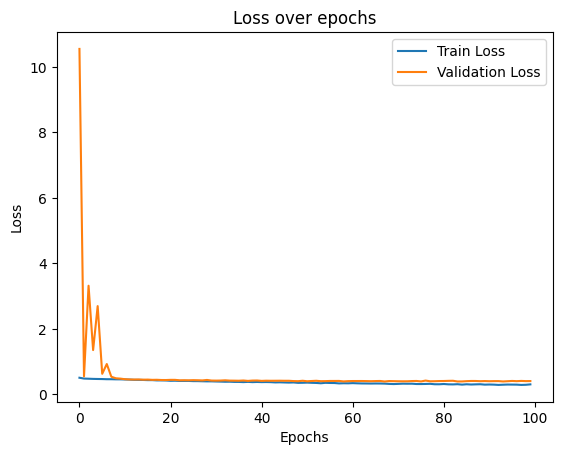

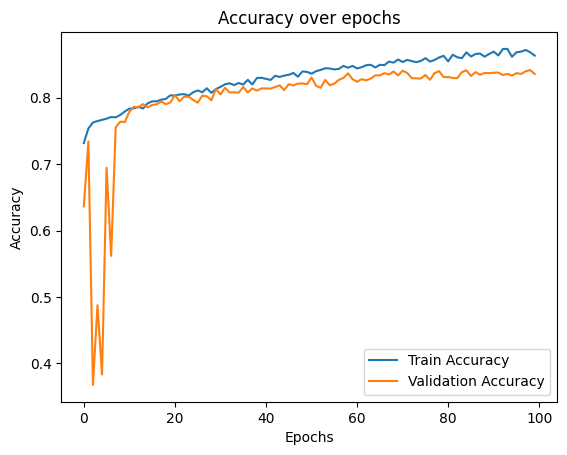

In [34]:
import matplotlib.pyplot as plt

# Loss 曲線
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

# Accuracy 曲線
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


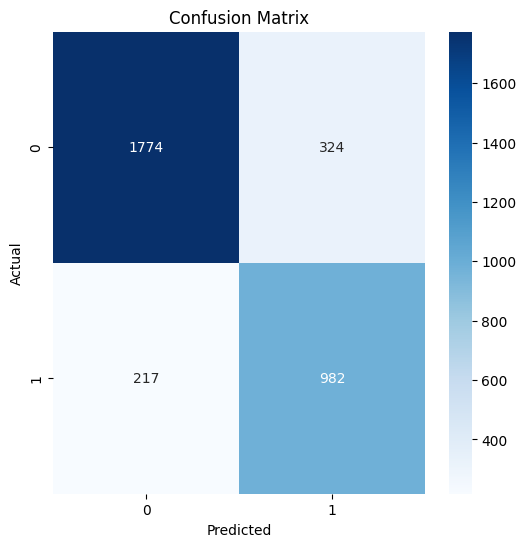

Classification Report:

              precision    recall  f1-score   support

           0     0.8910    0.8456    0.8677      2098
           1     0.7519    0.8190    0.7840      1199

    accuracy                         0.8359      3297
   macro avg     0.8215    0.8323    0.8259      3297
weighted avg     0.8404    0.8359    0.8373      3297



In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 預測結果
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)  # 轉換為二分類結果

# 計算混淆矩陣
cm_f = confusion_matrix(y_test, y_pred_class)

# 繪製混淆矩陣
plt.figure(figsize=(6, 6))
sns.heatmap(cm_f, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_class, digits=4))

In [36]:
#history_df = pd.DataFrame(history.history)
#history_df.sort_values(by='acc', ascending=False)

## Attention Mechanism

In [37]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, MultiHeadAttention, Flatten, GlobalAveragePooling1D, Reshape
from tensorflow.keras.models import Model

#
with mlflow.start_run(run_name='AttentionMechanisim'):#mlflow
    mlflow.tensorflow.autolog()#mlflow    
    n_input = X_train.shape[1]
    # Model
    # 定義模型
    input_layer = Input(shape=(n_input,))
    x = BatchNormalization()(input_layer)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    # Reshape 輸入，以便進行注意力機制（將它變成三維張量）
    x = Reshape((1, 128))(x)  # 假設每個樣本有 128 個特徵，這樣就會有 1 個時間步
    # 添加多頭注意力層
    x_attention = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)  # query, key 和 value 都是 x
    x_attention = Dropout(0.1)(x_attention)
    # 將注意力層的輸出展平
    x_flattened = Flatten()(x_attention)
    # 經過展平後的處理
    x = Dense(128, activation='relu')(x_flattened)
    x = Dropout(0.1)(x)
    output = Dense(1, activation='sigmoid')(x)


    # Model
    model = Model(inputs=input_layer, outputs=output)
    model.summary()
    # 模型optimizer 和 learning rate
    initial_lr = 0.001
    from tensorflow.keras.optimizers import schedules
    lr_schedule = schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)
    from tensorflow.keras.optimizers import Adam
    optimizer = Adam(learning_rate=lr_schedule)

    model.compile(loss='bce', optimizer=optimizer, metrics=['acc', 'Recall', 'Precision'])
    # EarlyStopping: 根據 val_loss 停止訓練
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    # ModelCheckpoint: 儲存最佳模型
    checkpoint = ModelCheckpoint('./models_temp/attention_best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=128, verbose=1, callbacks=[early_stop, checkpoint])

    train_loss, train_acc, train_recall, train_precision = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_acc, test_recall, test_precision = model.evaluate(X_test, y_test, verbose=0)
    mlflow.log_metric("Train score", train_acc)#mlflow
    mlflow.log_metric("Test score", test_acc)#mlflow
    #註冊模型
    run_id = mlflow.active_run().info.run_id#mlflow
    result = mlflow.register_model(
        model_uri=f"runs:/{run_id}/model",  # 你要用 mlflow.log_model 存的位置
        name="attention-model"              # 註冊後的 model name
    )

    # 評估模型
    model.evaluate(X_test, y_test)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19)        │         76 │ input_layer_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │      2,560 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 128)    │          0 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 128)    │     66,048 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 1, 128)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 128)       │          0 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     16,512 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │        129 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 85,325 (333.30 KB)

 Trainable params: 85,287 (333.15 KB)

 Non-trainable params: 38 (152.00 B)

2025/05/02 21:42:10 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.
2025/05/02 21:42:10 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'


Epoch 1/200
55/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.5809 - Recall: 0.4613 - acc: 0.6930 - loss: 0.5486
Epoch 1: val_loss improved from inf to 8.79609, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - Precision: 0.5858 - Recall: 0.4803 - acc: 0.6972 - loss: 0.5443 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_acc: 0.6363 - val_loss: 8.7961
Epoch 2/200
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6478 - Recall: 0.6453 - acc: 0.7470 - loss: 0.4901
Epoch 2: val_loss improved from 8.79609 to 0.52241, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.6482 - Recall: 0.6497 - acc: 0.7477 - loss: 0.4898 - val_Precision: 0.6774 - val_Recall: 0.6689 - val_acc: 0.7637 - val_loss: 0.5224
Epoch 3/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6827 - Recall: 0.6450 - acc: 0.7575 - loss: 0.4759
Epoch 3: val_loss did not improve from 0.52241
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6816 - Recall: 0.6453 - acc: 0.7573 - loss: 0.4760 - val_Precision: 1.0000 - val_Recall: 0.0042 - val_acc: 0.6379 - val_loss: 1.3845
Epoch 4/200
51/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6264 - Recall: 0.6620 - acc: 0.7436 - loss: 0.4885
Epoch 4: val_loss did not improve from 0.52241
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6319 - Recall: 0.6652 - acc: 0.7461 - loss: 0.4868 - val_Precision: 0.4491 - val_Recall: 0.9483 - val_acc: 0.5581 - val_loss: 0.9718
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6673 - Recall: 0.6963 - acc: 0.7683 - loss: 0

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.6588 - Recall: 0.6906 - acc: 0.7608 - loss: 0.4695 - val_Precision: 0.6682 - val_Recall: 0.7123 - val_acc: 0.7668 - val_loss: 0.4786
Epoch 9/200
56/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6677 - Recall: 0.6844 - acc: 0.7640 - loss: 0.4653
Epoch 9: val_loss improved from 0.47864 to 0.47498, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.6676 - Recall: 0.6855 - acc: 0.7640 - loss: 0.4656 - val_Precision: 0.6888 - val_Recall: 0.6756 - val_acc: 0.7710 - val_loss: 0.4750
Epoch 10/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6743 - Recall: 0.6726 - acc: 0.7589 - loss: 0.4743
Epoch 10: val_loss improved from 0.47498 to 0.46637, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.6743 - Recall: 0.6727 - acc: 0.7591 - loss: 0.4742 - val_Precision: 0.6820 - val_Recall: 0.7281 - val_acc: 0.7777 - val_loss: 0.4664
Epoch 11/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6788 - Recall: 0.7041 - acc: 0.7709 - loss: 0.4592
Epoch 11: val_loss improved from 0.46637 to 0.46323, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.6787 - Recall: 0.7033 - acc: 0.7708 - loss: 0.4595 - val_Precision: 0.6976 - val_Recall: 0.6580 - val_acc: 0.7719 - val_loss: 0.4632
Epoch 12/200
58/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6676 - Recall: 0.6899 - acc: 0.7663 - loss: 0.4634
Epoch 12: val_loss improved from 0.46323 to 0.46019, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.6682 - Recall: 0.6897 - acc: 0.7664 - loss: 0.4635 - val_Precision: 0.7130 - val_Recall: 0.6547 - val_acc: 0.7786 - val_loss: 0.4602
Epoch 13/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6846 - Recall: 0.6589 - acc: 0.7756 - loss: 0.4520
Epoch 13: val_loss did not improve from 0.46019
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6846 - Recall: 0.6591 - acc: 0.7755 - loss: 0.4522 - val_Precision: 0.6743 - val_Recall: 0.7373 - val_acc: 0.7749 - val_loss: 0.4607
Epoch 14/200
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6798 - Recall: 0.6862 - acc: 0.7703 - loss: 0.4710
Epoch 14: val_loss did not improve from 0.46019
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6803 - Recall: 0.6854 - acc: 0.7704 - loss: 0.4703 - val_Precision: 0.6684 - val_Recall: 0.7481 - val_acc: 0.7734 - val_loss: 0.4662
Epoch 15/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6815 - Recall: 0.7017 - acc: 0.7749 - lo

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.6815 - Recall: 0.7015 - acc: 0.7748 - loss: 0.4609 - val_Precision: 0.6833 - val_Recall: 0.7415 - val_acc: 0.7810 - val_loss: 0.4545
Epoch 16/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6910 - Recall: 0.7093 - acc: 0.7783 - loss: 0.4556
Epoch 16: val_loss did not improve from 0.45447
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6908 - Recall: 0.7085 - acc: 0.7782 - loss: 0.4557 - val_Precision: 0.7170 - val_Recall: 0.6380 - val_acc: 0.7768 - val_loss: 0.4614
Epoch 17/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6942 - Recall: 0.6499 - acc: 0.7684 - loss: 0.4695
Epoch 17: val_loss did not improve from 0.45447
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.6942 - Recall: 0.6506 - acc: 0.7686 - loss: 0.4693 - val_Precision: 0.6921 - val_Recall: 0.6806 - val_acc: 0.7737 - val_loss: 0.4594
Epoch 18/200
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6899 - Recall: 0.6558 - acc: 0.7744 - lo

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6845 - Recall: 0.6951 - acc: 0.7742 - loss: 0.4559 - val_Precision: 0.6946 - val_Recall: 0.7248 - val_acc: 0.7840 - val_loss: 0.4535
Epoch 20/200
51/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6984 - Recall: 0.6629 - acc: 0.7718 - loss: 0.4597
Epoch 20: val_loss did not improve from 0.45354
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6987 - Recall: 0.6651 - acc: 0.7729 - loss: 0.4587 - val_Precision: 0.7085 - val_Recall: 0.7114 - val_acc: 0.7886 - val_loss: 0.4599
Epoch 21/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7003 - Recall: 0.7184 - acc: 0.7884 - loss: 0.4360
Epoch 21: val_loss improved from 0.45354 to 0.45303, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.7003 - Recall: 0.7182 - acc: 0.7883 - loss: 0.4362 - val_Precision: 0.7127 - val_Recall: 0.6806 - val_acc: 0.7840 - val_loss: 0.4530
Epoch 22/200
51/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7110 - Recall: 0.6656 - acc: 0.7833 - loss: 0.4544
Epoch 22: val_loss improved from 0.45303 to 0.45262, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.7088 - Recall: 0.6693 - acc: 0.7827 - loss: 0.4538 - val_Precision: 0.7078 - val_Recall: 0.7031 - val_acc: 0.7865 - val_loss: 0.4526
Epoch 23/200
57/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6992 - Recall: 0.7072 - acc: 0.7861 - loss: 0.4363
Epoch 23: val_loss improved from 0.45262 to 0.45212, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.6988 - Recall: 0.7062 - acc: 0.7856 - loss: 0.4371 - val_Precision: 0.7165 - val_Recall: 0.6831 - val_acc: 0.7865 - val_loss: 0.4521
Epoch 24/200
58/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7028 - Recall: 0.7096 - acc: 0.7875 - loss: 0.4412
Epoch 24: val_loss improved from 0.45212 to 0.44518, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.7020 - Recall: 0.7096 - acc: 0.7870 - loss: 0.4415 - val_Precision: 0.7235 - val_Recall: 0.7073 - val_acc: 0.7953 - val_loss: 0.4452
Epoch 25/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7064 - Recall: 0.6946 - acc: 0.7819 - loss: 0.4529
Epoch 25: val_loss did not improve from 0.44518
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.7064 - Recall: 0.6942 - acc: 0.7820 - loss: 0.4529 - val_Precision: 0.6993 - val_Recall: 0.7098 - val_acc: 0.7834 - val_loss: 0.4498
Epoch 26/200
57/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6969 - Recall: 0.7127 - acc: 0.7860 - loss: 0.4478
Epoch 26: val_loss did not improve from 0.44518
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - Precision: 0.6969 - Recall: 0.7129 - acc: 0.7859 - loss: 0.4475 - val_Precision: 0.7185 - val_Recall: 0.6747 - val_acc: 0.7856 - val_loss: 0.4496
Epoch 27/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7217 - Recall: 0.6943 - acc: 0.7912 - l

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.7049 - Recall: 0.7055 - acc: 0.7898 - loss: 0.4341 - val_Precision: 0.6935 - val_Recall: 0.7323 - val_acc: 0.7850 - val_loss: 0.4405
Epoch 31/200
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6976 - Recall: 0.6699 - acc: 0.7822 - loss: 0.4399
Epoch 31: val_loss did not improve from 0.44055
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6989 - Recall: 0.6741 - acc: 0.7827 - loss: 0.4394 - val_Precision: 0.6962 - val_Recall: 0.7473 - val_acc: 0.7895 - val_loss: 0.4425
Epoch 32/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7129 - Recall: 0.7233 - acc: 0.7917 - loss: 0.4371
Epoch 32: val_loss did not improve from 0.44055
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7127 - Recall: 0.7226 - acc: 0.7915 - loss: 0.4370 - val_Precision: 0.7040 - val_Recall: 0.7239 - val_acc: 0.7889 - val_loss: 0.4421
Epoch 33/200
58/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7133 - Recall: 0.7048 - acc: 0.7923 - lo

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.6989 - Recall: 0.7002 - acc: 0.7852 - loss: 0.4401 - val_Precision: 0.7196 - val_Recall: 0.7214 - val_acc: 0.7965 - val_loss: 0.4400
Epoch 35/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7230 - Recall: 0.7163 - acc: 0.7990 - loss: 0.4314
Epoch 35: val_loss did not improve from 0.44005
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7227 - Recall: 0.7160 - acc: 0.7988 - loss: 0.4315 - val_Precision: 0.6753 - val_Recall: 0.8065 - val_acc: 0.7886 - val_loss: 0.4466
Epoch 36/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6900 - Recall: 0.7539 - acc: 0.7885 - loss: 0.4357
Epoch 36: val_loss did not improve from 0.44005
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.6908 - Recall: 0.7521 - acc: 0.7886 - loss: 0.4358 - val_Precision: 0.7366 - val_Recall: 0.6647 - val_acc: 0.7916 - val_loss: 0.4407
Epoch 37/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7266 - Recall: 0.6691 - acc: 0.7892 - lo

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6994 - Recall: 0.6673 - acc: 0.7773 - loss: 0.4403 - val_Precision: 0.7022 - val_Recall: 0.7356 - val_acc: 0.7904 - val_loss: 0.4383
Epoch 41/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7188 - Recall: 0.7032 - acc: 0.7874 - loss: 0.4414
Epoch 41: val_loss improved from 0.43831 to 0.43620, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.7186 - Recall: 0.7034 - acc: 0.7877 - loss: 0.4409 - val_Precision: 0.7087 - val_Recall: 0.7448 - val_acc: 0.7959 - val_loss: 0.4362
Epoch 42/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7100 - Recall: 0.7179 - acc: 0.7932 - loss: 0.4327
Epoch 42: val_loss did not improve from 0.43620
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.7102 - Recall: 0.7175 - acc: 0.7932 - loss: 0.4327 - val_Precision: 0.6950 - val_Recall: 0.7640 - val_acc: 0.7922 - val_loss: 0.4395
Epoch 43/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7150 - Recall: 0.7245 - acc: 0.7929 - loss: 0.4295
Epoch 43: val_loss did not improve from 0.43620
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7149 - Recall: 0.7243 - acc: 0.7929 - loss: 0.4295 - val_Precision: 0.7123 - val_Recall: 0.7248 - val_acc: 0.7934 - val_loss: 0.4385
Epoch 44/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7113 - Recall: 0.7064 - acc: 0.7957 - lo

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.7279 - Recall: 0.6862 - acc: 0.7975 - loss: 0.4266 - val_Precision: 0.7024 - val_Recall: 0.7540 - val_acc: 0.7944 - val_loss: 0.4337
Epoch 46/200
51/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7191 - Recall: 0.7247 - acc: 0.7972 - loss: 0.4198
Epoch 46: val_loss did not improve from 0.43370
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.7186 - Recall: 0.7222 - acc: 0.7966 - loss: 0.4205 - val_Precision: 0.7190 - val_Recall: 0.7214 - val_acc: 0.7962 - val_loss: 0.4361
Epoch 47/200
51/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7080 - Recall: 0.7281 - acc: 0.7933 - loss: 0.4328
Epoch 47: val_loss did not improve from 0.43370
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7088 - Recall: 0.7255 - acc: 0.7933 - loss: 0.4319 - val_Precision: 0.7139 - val_Recall: 0.7306 - val_acc: 0.7956 - val_loss: 0.4360
Epoch 48/200
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7254 - Recall: 0.6943 - acc: 0.7924 - lo

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.7326 - Recall: 0.7320 - acc: 0.8072 - loss: 0.4117 - val_Precision: 0.7137 - val_Recall: 0.7673 - val_acc: 0.8035 - val_loss: 0.4335
Epoch 50/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7204 - Recall: 0.7157 - acc: 0.7973 - loss: 0.4237
Epoch 50: val_loss did not improve from 0.43354
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.7206 - Recall: 0.7157 - acc: 0.7974 - loss: 0.4236 - val_Precision: 0.7062 - val_Recall: 0.7656 - val_acc: 0.7989 - val_loss: 0.4338
Epoch 51/200
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7110 - Recall: 0.7163 - acc: 0.7979 - loss: 0.4287
Epoch 51: val_loss did not improve from 0.43354
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7128 - Recall: 0.7173 - acc: 0.7981 - loss: 0.4281 - val_Precision: 0.7291 - val_Recall: 0.6914 - val_acc: 0.7944 - val_loss: 0.4337
Epoch 52/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7304 - Recall: 0.7038 - acc: 0.8029 - lo

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.7303 - Recall: 0.7043 - acc: 0.8029 - loss: 0.4140 - val_Precision: 0.7216 - val_Recall: 0.7373 - val_acc: 0.8010 - val_loss: 0.4291
Epoch 53/200
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7428 - Recall: 0.6922 - acc: 0.8016 - loss: 0.4194
Epoch 53: val_loss did not improve from 0.42909
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7412 - Recall: 0.6954 - acc: 0.8018 - loss: 0.4189 - val_Precision: 0.7381 - val_Recall: 0.6839 - val_acc: 0.7968 - val_loss: 0.4334
Epoch 54/200
53/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7273 - Recall: 0.7120 - acc: 0.8023 - loss: 0.4144
Epoch 54: val_loss did not improve from 0.42909
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - Precision: 0.7279 - Recall: 0.7133 - acc: 0.8025 - loss: 0.4148 - val_Precision: 0.7209 - val_Recall: 0.7348 - val_acc: 0.8001 - val_loss: 0.4307
Epoch 55/200
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7376 - Recall: 0.7367 - acc: 0.8053 - l

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.7198 - Recall: 0.7438 - acc: 0.8041 - loss: 0.4110 - val_Precision: 0.7153 - val_Recall: 0.7565 - val_acc: 0.8019 - val_loss: 0.4274
Epoch 57/200
57/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7169 - Recall: 0.7272 - acc: 0.7967 - loss: 0.4265
Epoch 57: val_loss did not improve from 0.42739
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.7171 - Recall: 0.7263 - acc: 0.7967 - loss: 0.4263 - val_Precision: 0.7073 - val_Recall: 0.7456 - val_acc: 0.7953 - val_loss: 0.4313
Epoch 58/200
58/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7437 - Recall: 0.7584 - acc: 0.8179 - loss: 0.4071
Epoch 58: val_loss improved from 0.42739 to 0.42676, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.7429 - Recall: 0.7566 - acc: 0.8172 - loss: 0.4077 - val_Precision: 0.7393 - val_Recall: 0.6931 - val_acc: 0.7995 - val_loss: 0.4268
Epoch 59/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7536 - Recall: 0.6820 - acc: 0.8053 - loss: 0.4172
Epoch 59: val_loss did not improve from 0.42676
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7532 - Recall: 0.6827 - acc: 0.8053 - loss: 0.4172 - val_Precision: 0.7364 - val_Recall: 0.7014 - val_acc: 0.8001 - val_loss: 0.4306
Epoch 60/200
51/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7260 - Recall: 0.7153 - acc: 0.7986 - loss: 0.4210
Epoch 60: val_loss did not improve from 0.42676
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7269 - Recall: 0.7162 - acc: 0.7994 - loss: 0.4199 - val_Precision: 0.7292 - val_Recall: 0.7006 - val_acc: 0.7965 - val_loss: 0.4319
Epoch 61/200
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7535 - Recall: 0.7237 - acc: 0.8160 - lo

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.7461 - Recall: 0.7130 - acc: 0.8090 - loss: 0.4017 - val_Precision: 0.7317 - val_Recall: 0.7440 - val_acc: 0.8077 - val_loss: 0.4251
Epoch 67/200
58/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7517 - Recall: 0.7436 - acc: 0.8140 - loss: 0.4096
Epoch 67: val_loss did not improve from 0.42514
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.7507 - Recall: 0.7421 - acc: 0.8135 - loss: 0.4097 - val_Precision: 0.7297 - val_Recall: 0.7273 - val_acc: 0.8029 - val_loss: 0.4274
Epoch 68/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7223 - Recall: 0.7147 - acc: 0.8007 - loss: 0.4180
Epoch 68: val_loss did not improve from 0.42514
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7230 - Recall: 0.7148 - acc: 0.8009 - loss: 0.4177 - val_Precision: 0.7336 - val_Recall: 0.7348 - val_acc: 0.8065 - val_loss: 0.4252
Epoch 69/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7383 - Recall: 0.7341 - acc: 0.8130 - lo

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.7561 - Recall: 0.7400 - acc: 0.8203 - loss: 0.3949 - val_Precision: 0.7228 - val_Recall: 0.7481 - val_acc: 0.8041 - val_loss: 0.4249
Epoch 71/200
57/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7610 - Recall: 0.7419 - acc: 0.8193 - loss: 0.3966
Epoch 71: val_loss improved from 0.42490 to 0.41990, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.7598 - Recall: 0.7415 - acc: 0.8189 - loss: 0.3969 - val_Precision: 0.7575 - val_Recall: 0.7164 - val_acc: 0.8135 - val_loss: 0.4199
Epoch 72/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7458 - Recall: 0.7322 - acc: 0.8133 - loss: 0.3983
Epoch 72: val_loss improved from 0.41990 to 0.41845, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.7455 - Recall: 0.7322 - acc: 0.8132 - loss: 0.3984 - val_Precision: 0.7472 - val_Recall: 0.7123 - val_acc: 0.8077 - val_loss: 0.4184
Epoch 73/200
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7572 - Recall: 0.7129 - acc: 0.8139 - loss: 0.3980
Epoch 73: val_loss did not improve from 0.41845
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7555 - Recall: 0.7145 - acc: 0.8135 - loss: 0.3991 - val_Precision: 0.7210 - val_Recall: 0.7373 - val_acc: 0.8007 - val_loss: 0.4232
Epoch 74/200
53/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7211 - Recall: 0.7434 - acc: 0.7968 - loss: 0.4307
Epoch 74: val_loss did not improve from 0.41845
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7231 - Recall: 0.7417 - acc: 0.7984 - loss: 0.4280 - val_Precision: 0.7274 - val_Recall: 0.7456 - val_acc: 0.8059 - val_loss: 0.4206
Epoch 75/200
51/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7418 - Recall: 0.7204 - acc: 0.8078 - lo

2025/05/02 21:42:53 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2025/05/02 21:42:53 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/05/02 21:42:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  1/104 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - Precision: 0.9231 - Recall: 0.8000 - acc: 0.8750 - loss: 0.5183

Successfully registered model 'attention-model'.
Created version '1' of model 'attention-model'.


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Precision: 0.7498 - Recall: 0.7155 - acc: 0.8126 - loss: 0.4233


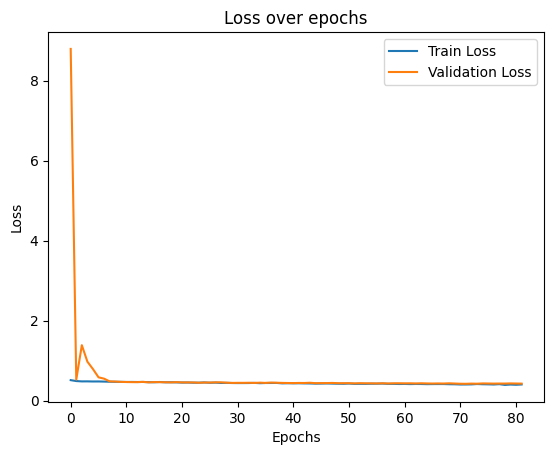

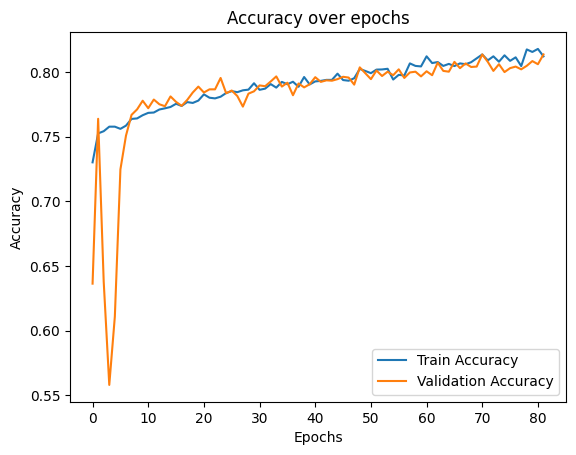

In [38]:
import matplotlib.pyplot as plt

# Loss 曲線
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

# Accuracy 曲線
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


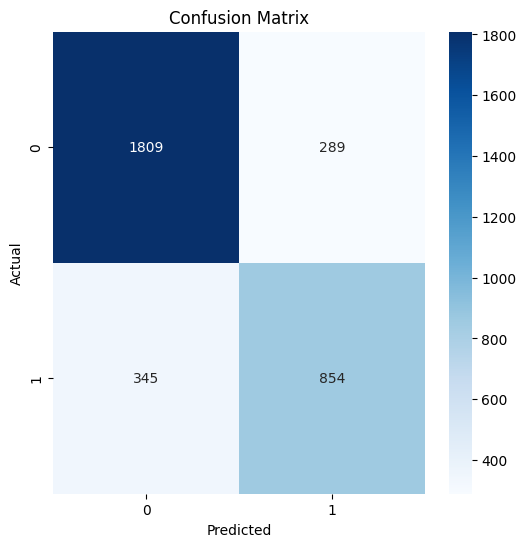

Classification Report:

              precision    recall  f1-score   support

           0     0.8398    0.8622    0.8509      2098
           1     0.7472    0.7123    0.7293      1199

    accuracy                         0.8077      3297
   macro avg     0.7935    0.7873    0.7901      3297
weighted avg     0.8061    0.8077    0.8067      3297



In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 預測結果
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)  # 轉換為二分類結果

# 計算混淆矩陣
cm_a = confusion_matrix(y_test, y_pred_class)

# 繪製混淆矩陣
plt.figure(figsize=(6, 6))
sns.heatmap(cm_a, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_class, digits=4))